In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, accuracy_score, roc_auc_score, auc, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')
len(df)

1319

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
df['card'] = (df['card'] == 'yes').astype(int)

In [5]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [10]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)

y_train = df_train.card.values
y_val = df_val.card.values

del df_train['card']
del df_val['card']


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [23]:
roc_auc_score(y_train, df_train['reports'])

0.2819244604316547

In [27]:
roc_auc_score(y_train, -df_train['reports'])

0.7180755395683454

In [24]:
roc_auc_score(y_train, df_train['dependents'])

0.4737769784172661

In [28]:
roc_auc_score(y_train, -df_train['dependents'])

0.5262230215827338

In [25]:
roc_auc_score(y_train, df_train['active'])

0.5951798561151079

In [26]:
roc_auc_score(y_train, df_train['share'])

0.9936091127098321

`share` has the highest AUC score.

In [17]:

cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [18]:
train_dict = df_train[cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, 
    max_iter=1000,)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [29]:
val_dict = df_val[cols].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, y_pred), 3)

0.991

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8
## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [38]:
thresholds = np.linspace(0, 1, 101)

accuracies = []
precision = []
recall = []
f1 = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    pres = precision_score(y_val, y_pred>= t)
    precision.append(pres)
    rec = recall_score(y_val, y_pred>=t)
    recall.append(rec)
    f1.append((2 * pres * rec)/(pres + rec))
    #print('%0.2f %0.3f' % (t, acc))

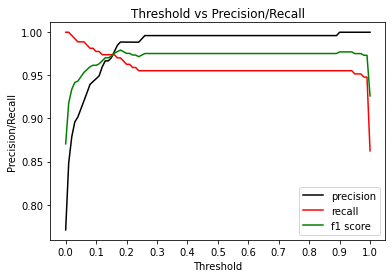

In [39]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, precision, color='black', label='precision')
plt.plot(thresholds, recall, color='red', label='recall')
plt.plot(thresholds, f1, color='green', label='f1 score')

plt.title('Threshold vs Precision/Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend(loc='best')
plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [41]:
def train(df, y):
    cat = df[cols].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[cols].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [42]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [43]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.card.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [44]:

np.array(aucs).round(3)

array([0.994, 0.994, 0.994, 1.   , 1.   ])

In [45]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.996 ± 0.003


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [47]:
def train(df, y, C=1.0):
    cat = df[cols].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [48]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.01, auc = 0.992 ± 0.006
C=0.1, auc = 0.995 ± 0.004
C=1, auc = 0.996 ± 0.003
C=10, auc = 0.996 ± 0.003
